# Learning the antiderivative operator from an aligned dataset

We will learn the antiderivative operator 

TODO: get markdown math expressions or latex working. Expressions not complete.

```
$$
G: v \mapsto u
$$
```

### References
[1] [Antiderivative operator from an aligned dataset - DeepXDE](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html)

[2] [DeepONet Tutorial in JAX](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb)

## Current issues / TODOs
* Need to figure out how hard it would be to transpose the data back to the intended shape
* Need to implement a problem predict method, why is data['name'] prepended
* Am i using the correct loss metric? currently MSE but deepxde uses "mean l2 relative error"
* Should I be using a callback for keeping track of loss?
* Identify where the mixed integer programming is implemented in DeepXDE
* Should the data be moved somewhere out of the repo?

## Completed tasks
* Tested batch size, batch size must be >= 100 due to dimensions of MLP linear transformation 100x40
* Early stopping working correctly, I accidentally set warmup=epochs during debug
* Add DeepXDE example w/ PyTorch backend to notebook
* Performance comparison for DeepXDE 
    * Time (basic)
    * Decided not to do 
        * Memory
        * Loss (different losses at the moment)
* Neuromancer files edited
    * src/neuromancer/trainer.py - Added loss history for train and dev epochs
    * src/neuromancer/modules/blocks.py - Added DeepONet class definition
* Decided not to add option to initialize linear for MLPs w/ Glorot normal aka xavier uniform
    * [https://pouannes.github.io/blog/initialization/](https://pouannes.github.io/blog/initialization/)
    * [torch.nn.init.xavier_uniform_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_)
* Implemented a DeepONet class inheriting from Block
* Skipping setting up a dev dataset split until we have on the fly generated data

### Import

In [29]:
# https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import sys
sys.path.append('neuromancer_deeponet/src')

In [30]:
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.problem import Problem
from neuromancer.system import Node
from neuromancer.trainer import Trainer

In [31]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

In [32]:
def prepare_data(dataset, name):
    ## Note: transposing branch input because DictDataset in Neuromancer needs all tensors in the dict to have the same shape at index 0
    branch_inputs = dataset["X"][0].T
    trunk_inputs = dataset["X"][1]
    outputs = dataset["y"].T

    #print(branch_inputs_train.shape)
    #print(trunk_inputs_train.shape)
    #print(outputs_train.shape)

    ## Global definition of Nu and Nsamples:
    ## This example has 100 points (resolution of x and u(x))
    ## and 150 samples of functions
    Nu = outputs.shape[0]
    Nsamples = outputs.shape[1]
    print(f'Nu = {Nu}')
    print(f'Nsamples = {Nsamples}')

    # convert to pytorch tensors of float type
    t_branch_inputs_train = torch.from_numpy(branch_inputs).float()
    t_trunk_inputs_train = torch.from_numpy(trunk_inputs).float()
    t_outputs_train = torch.from_numpy(outputs).float()

    data = DictDataset({
        "branch_inputs": t_branch_inputs_train,
        "trunk_inputs": t_trunk_inputs_train,
        "outputs": t_outputs_train
    }, name=name)

    return data, Nu

### Create named dictionary datasets

In [35]:
#train_data = DictDataset(samples_train, name="train")
#dev_data = DictDataset(samples_dev, name="dev")
#test_data = DictDataset(samples_test, name="test")
data_dir = "examples/DeepONets/datasets"
dataset_train = np.load(f"{data_dir}/antiderivative_aligned_train.npz", allow_pickle=True)
train_data, Nu_train = prepare_data(dataset_train, name="train")

dataset_test = np.load(f"{data_dir}/antiderivative_aligned_test.npz", allow_pickle=True)
test_data, Nu_test = prepare_data(dataset_test, name="test")
print(f"Nu_train == Nu_test {Nu_train == Nu_test}")
Nu = Nu_train

Nu = 100
Nsamples = 150
Nu = 100
Nsamples = 1000
Nu_train == Nu_test True


### Create torch DataLoaders for the Trainer

In [36]:
batch_size = 100
print(f"batch_size: {batch_size}")
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=train_data.collate_fn, shuffle=False)
#dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size, collate_fn=dev_data.collate_fn, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=test_data.collate_fn, shuffle=False)

batch_size: 100


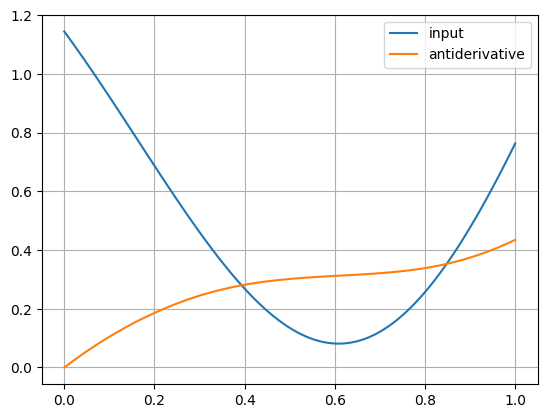

In [37]:
# Due to the dataset being aligned, we can use the trunk inputs as a grid
k = 2
plt.plot(
    train_data.datadict['trunk_inputs'],
    train_data.datadict['branch_inputs'][:,k],
    label="input",
)
plt.plot(
    train_data.datadict['trunk_inputs'],
    train_data.datadict['outputs'][:,k],
    label="antiderivative",
)
plt.legend()
plt.grid()

## Define nodes

In [38]:
in_size_branch = Nu
width_size = 40
depth_branch = 2
interact_size = 40
in_size_trunk = 1
depth_trunk = 2
block_deeponet = blocks.DeepONet(
    insize_branch=in_size_branch,
    insize_trunk=in_size_trunk,
    widthsize=width_size,
    interactsize=interact_size,
    depth_branch=depth_branch,
    depth_trunk=depth_trunk,
    nonlin=activations['relu'],
    bias=True
)

In [39]:
node_deeponet = Node(block_deeponet, ['branch_inputs', 'trunk_inputs'], ['g'], name="deeponet")
print(node_deeponet)

deeponet(branch_inputs, trunk_inputs) -> g


## Objective and Constraints in NeuroMANCER

In [40]:
var_y_est = variable("g")
var_y_true = variable("outputs")

# node implementation
#nodes = [node_transpose_branch, branch_net, trunk_net, node_multiply]

# class implementation
nodes = [node_deeponet]

var_loss = (var_y_est == var_y_true.T)^2

# need to implement "mean l2 relative error" from deepxde
#var_loss = (((var_y_est - var_y_true.T) / var_y_true.T + 0.000000000001) == 0.0)^2
# https://pytorch.org/docs/stable/generated/torch.linalg.norm.html
#var_loss = torch.linalg.norm(var_y_true - var_y_est, axis=1) / torch.linalg.norm(var_y_true, axis=1)
#var_loss = (var_y_est == var_y_true) / var_y_true
var_loss.name = "residual_loss"
objectives = [var_loss]

loss = PenaltyLoss(objectives, constraints=[])

problem = Problem(nodes, loss=loss, grad_inference=True)


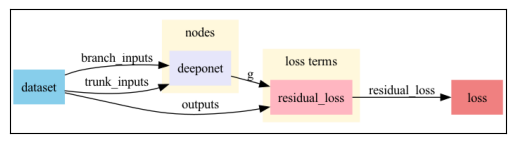

In [41]:
# brew install graphviz
problem.show()

## Problem Solution in NeuroMANCER

In [42]:
lr = 0.001              # step size for gradient descent
epochs = 10000          # number of training epochs
epoch_verbose = 100     # print loss when this many epochs have occurred
warmup = 100            # number of epochs to wait before enacting early stopping policy
patience = 5            #  number of epochs with no improvement in eval metric to allow before early stopping

In [43]:
optimizer = torch.optim.Adam(problem.parameters(), lr=lr) # double check Adam params


# define trainer
trainer = Trainer(
    problem,
    #problem.to(device),
    train_data=train_loader,
    #dev_data=test_loader,
    optimizer=optimizer,
    epochs=epochs,
    patience=patience,
    epoch_verbose=epoch_verbose,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup = warmup,
    #device=device
)

In [44]:
%%time
best_model = trainer.train()


epoch: 0  train_loss: 0.25070300698280334
epoch: 100  train_loss: 0.0036618574522435665
epoch: 200  train_loss: 0.001337062451057136
epoch: 300  train_loss: 0.00043787728645838797
epoch: 400  train_loss: 0.00033489629277028143
epoch: 500  train_loss: 0.0002972391957882792
Early stopping!!!
CPU times: user 1.94 s, sys: 7.58 s, total: 9.52 s
Wall time: 1.41 s


In [45]:
train_loss_history = [l.detach().numpy() for l in trainer.loss_history["train"]]
dev_loss_history = [l.detach().numpy() for l in trainer.loss_history["dev"]]
print(f"len(train_loss_history): {len(train_loss_history)}")
print(f"len(dev_loss_history): {len(dev_loss_history)}")

len(train_loss_history): 562
len(dev_loss_history): 0


## plot loss history

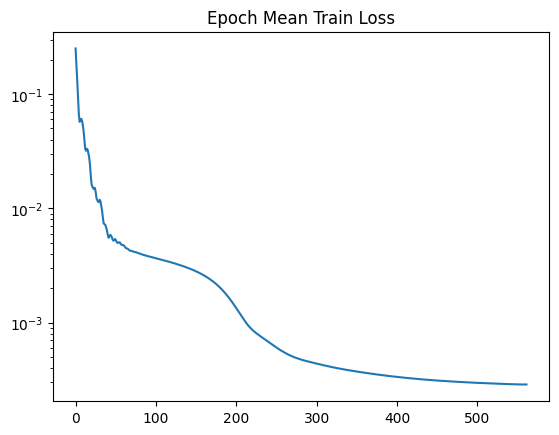

In [46]:
plt.semilogy(train_loss_history)
plt.title("Epoch Mean Train Loss")
plt.show()

## test trainer (need to add dev dataset)

In [47]:
#best_outputs = trainer.test(best_model)

In [48]:
# load best trained model
#problem.load_state_dict(best_model)

In [49]:
# (not working) Evaluate trained PINN on data (all the data in the domain)
#val_u = problem(train_data.datadict)


## Compare results

torch.Size([100, 1]) torch.Size([100, 1])


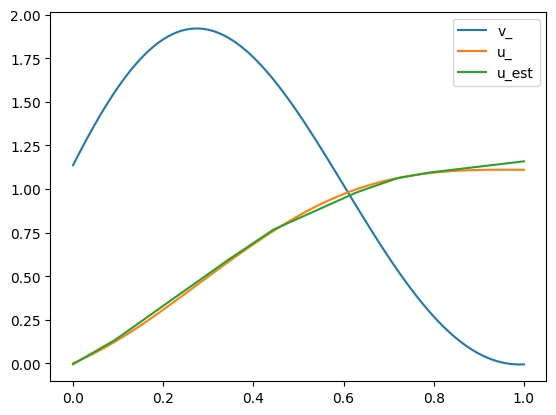

In [50]:
k = 0 # k is the k-th function among the 1000 test functions
v_ = test_data.datadict["branch_inputs"][:,k].reshape(-1,1)
x_ = test_data.datadict["trunk_inputs"]
#v_ = train_data.datadict["branch_inputs"][:,k].reshape(-1,1)
#x_ = train_data.datadict["trunk_inputs"]
print(v_.shape, x_.shape)


## Note: Neuromancer needs a better forward method to 'predict' after the model is trained
## This is a workaround that I found (forward pass with zero 'outputs')
## You could also use a problem.step({'branch_inputs':v_, 'trunk_inputs':x_}) here, but that is not as great
## as it computes the gradients again.
res = problem.step({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = test_data.datadict["outputs"][:,k]
#u_ = train_data.datadict["outputs"][:,k]
u_est = res['g'].T

plt.plot(x_.detach().numpy(), v_.detach().numpy(),label='v_')
plt.plot(x_.detach().numpy(), u_.detach().numpy(),label='u_')
plt.plot(x_.detach().numpy(), u_est.detach().numpy(),label='u_est')

plt.legend()


torch.Size([100, 1]) torch.Size([100, 1])


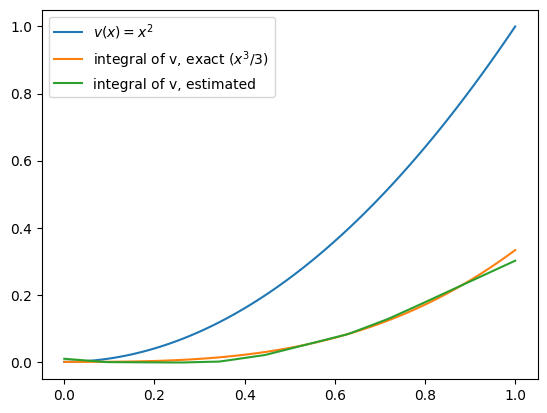

In [51]:
x_ = train_data.datadict["trunk_inputs"]
v_ = torch.pow(x_,2).reshape(-1,1)

print(v_.shape, x_.shape)
res = problem.step({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = (1./3.)*torch.pow(x_,3).reshape(-1,1)
u_est = res['g'].T

plt.plot(x_.detach().numpy(), v_.detach().numpy(),label='$v(x) = x^2$')
plt.plot(x_.detach().numpy(), u_.detach().numpy(),label='integral of v, exact ($x^3/3$)')
plt.plot(x_.detach().numpy(), u_est.detach().numpy(),label='integral of v, estimated')
plt.legend()


## Compare: NeuroMANCER vs. DeepXDE

In [52]:
%env DDE_BACKEND=pytorch

import deepxde as dde

env: DDE_BACKEND=pytorch


In [53]:
# Load dataset
X_train = (dataset_train["X"][0].astype(np.float32), dataset_train["X"][1].astype(np.float32))
y_train = dataset_train["y"].astype(np.float32)
X_test = (dataset_test["X"][0].astype(np.float32), dataset_test["X"][1].astype(np.float32))
y_test = dataset_test["y"].astype(np.float32)

data = dde.data.TripleCartesianProd(
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)

In [54]:
# Choose a network
m = 100
dim_x = 1
net = dde.nn.DeepONetCartesianProd(
    [m, 40, 40],
    [dim_x, 40, 40],
    "relu",
    "Glorot normal",
)

In [55]:
# Define a Model
model = dde.Model(data, net)

In [56]:
# Compile and Train
model.compile("adam", lr=0.001, metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 0.000401 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [9.04e-01]    [7.74e-01]    [1.67e+00]    
1000      [2.31e-04]    [2.61e-04]    [5.69e-02]    
2000      [3.34e-05]    [5.36e-05]    [2.72e-02]    
3000      [2.02e-05]    [3.51e-05]    [2.27e-02]    
4000      [1.80e-05]    [3.05e-05]    [2.13e-02]    
5000      [6.43e-05]    [8.95e-05]    [2.68e-02]    
6000      [1.52e-05]    [2.56e-05]    [1.89e-02]    
7000      [1.24e-05]    [1.98e-05]    [1.72e-02]    
8000      [8.66e-06]    [1.59e-05]    [1.55e-02]    
9000      [9.72e-06]    [1.41e-05]    [1.48e-02]    
10000     [5.33e-06]    [1.07e-05]    [1.36e-02]    

Best model at step 10000:
  train loss: 5.33e-06
  test loss: 1.07e-05
  test metric: [1.36e-02]

'train' took 8.580134 s



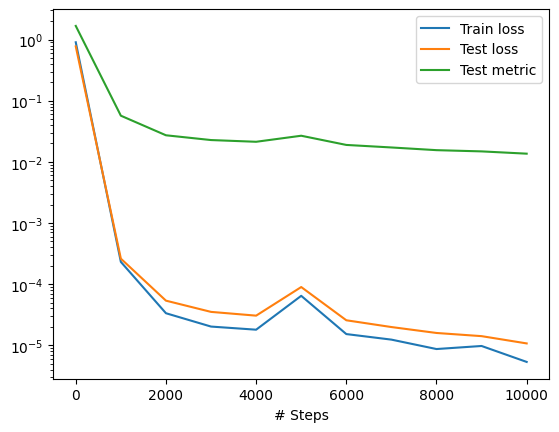

In [57]:
# Plot the loss trajectory
dde.utils.plot_loss_history(losshistory)
plt.show()


In [58]:
k = 0 # k is the k-th function among the 1000 test functions
v_ = test_data.datadict["branch_inputs"][:,k]
x_ = test_data.datadict["trunk_inputs"]
#v_ = train_data.datadict["branch_inputs"][:,k].reshape(-1,1)
#x_ = train_data.datadict["trunk_inputs"]
print(v_.shape, x_.shape)


## Note: Neuromancer needs a better forward method to 'predict' after the model is trained
## This is a workaround that I found (forward pass with zero 'outputs')
## You could also use a problem.step({'branch_inputs':v_, 'trunk_inputs':x_}) here, but that is not as great
## as it computes the gradients again.
#res = problem.step({'branch_inputs':v_, 'trunk_inputs':x_})
res = model.predict((X_test[0][k], X_test[1][:,None]))

u_ = test_data.datadict["outputs"][:,k]
#u_ = train_data.datadict["outputs"][:,k]
u_est = res['g'].T

plt.plot(x_.detach().numpy(), v_.detach().numpy(),label='v_')
plt.plot(x_.detach().numpy(), u_.detach().numpy(),label='u_')
plt.plot(x_.detach().numpy(), u_est.detach().numpy(),label='u_est')

plt.legend()

torch.Size([100]) torch.Size([100, 1])


RuntimeError: einsum(): the number of subscripts in the equation (2) does not match the number of dimensions (1) for operand 0 and no ellipsis was given